In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path

# 当前目录
current_dir = os.path.dirname(os.path.abspath('__file__'))
# 上一级目录
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
# 上两级目录
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)

from config_plot import *
from utils import Logger, read_config_file, set_random_seed, tensors_to_numpy,count_parameters, load_network,to_pickle, from_pickle
from dynamic_single_pendulum_DAE import DynamicSinglePendulumDAE
from data import get_data
from network import DAE_NN
from integrator import ODEIntegrate

# config

In [2]:
seed = 0
set_random_seed(seed)

os.makedirs(output_dir, exist_ok=True)  

# Logger
logger = Logger(output_dir)
logger.info("#" * 100)

2023-09-26 22:46:27 INFO ####################################################################################################


# infer

In [3]:
config_file_path = "/home/lbu/project/pixels_hnn/ex_single_pendulum3/config.py"
config = read_config_file(config_file_path)
config

<module 'config' from '/home/lbu/project/pixels_hnn/ex_single_pendulum3/config.py'>

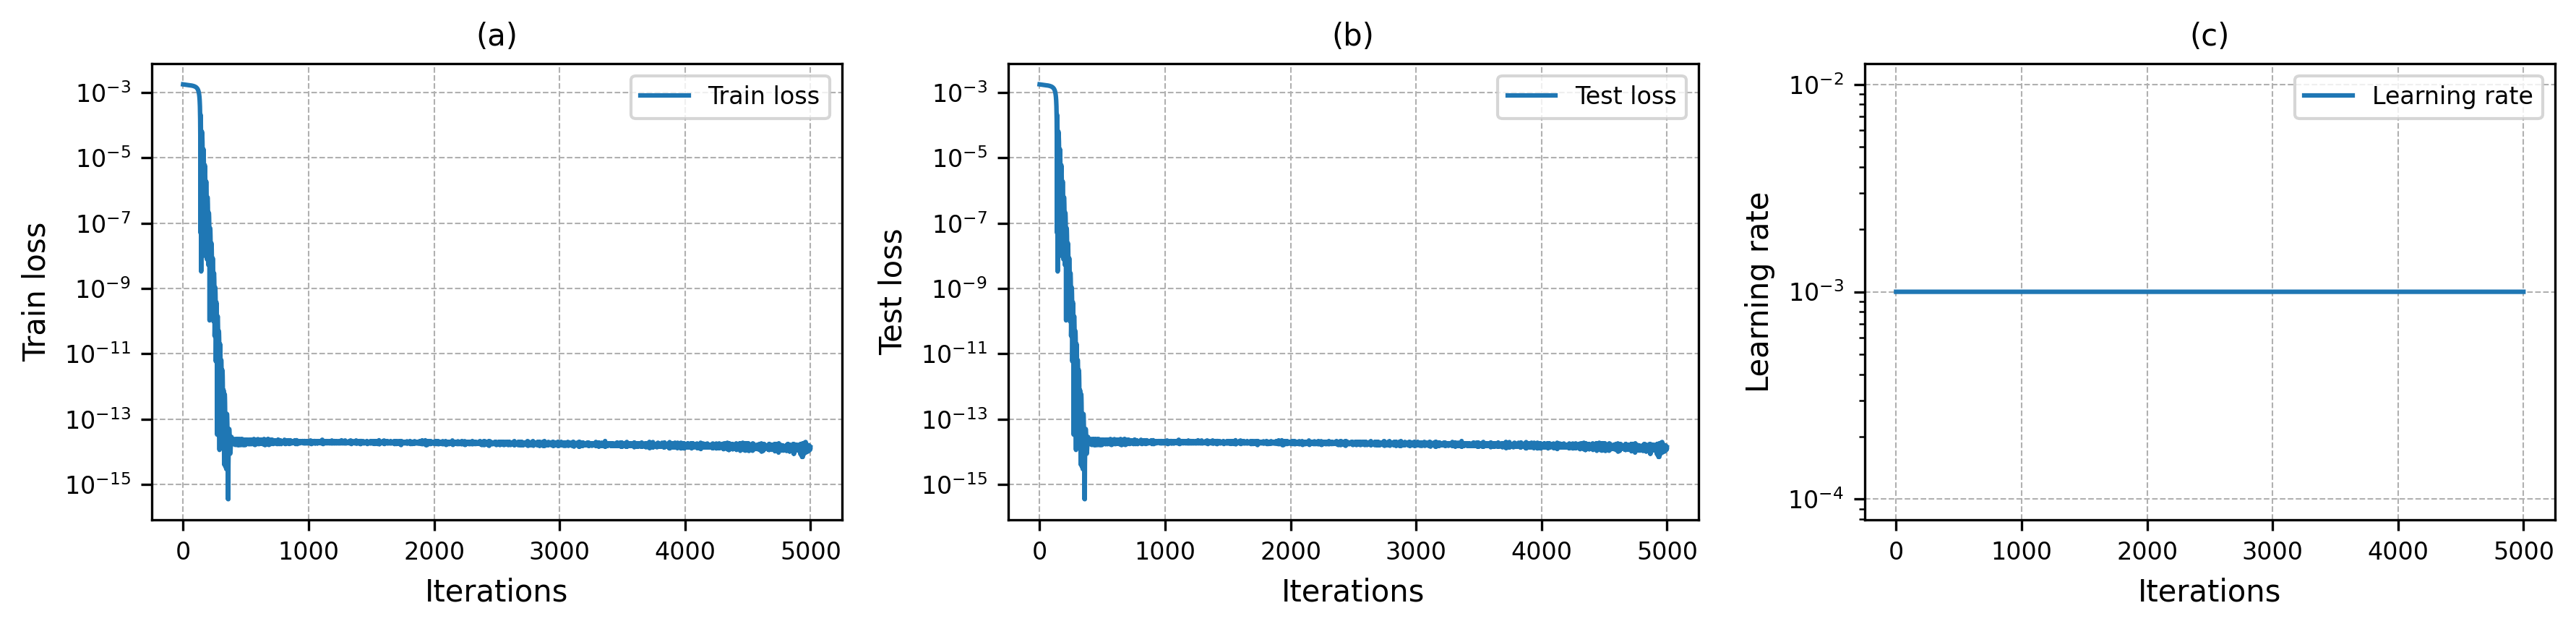

In [4]:
path = "/home/lbu/project/pixels_hnn/ex_single_pendulum3/outputs/loss.pkl"
loss_info = from_pickle(path)
iterations = loss_info["iter"]
train_loss = loss_info["train_loss"]
test_loss = loss_info["test_loss"]

fig, axs = plt.subplots(1, 3, figsize=(4 * 3, 3 * 1), dpi=Latex_DPI)

subfig = axs[0]
subfig.set_title('(a)')
subfig.set_xlabel('Iterations')
subfig.set_ylabel('Train loss')
subfig.plot(iterations, train_loss, label='Train loss')
subfig.set_yscale('log')  
subfig.legend()

subfig = axs[1]
subfig.set_title('(b)')
subfig.set_xlabel('Iterations')
subfig.set_ylabel('Test loss')
subfig.plot(iterations, train_loss, label='Test loss')
subfig.set_yscale('log')  
subfig.legend()

subfig = axs[2]
subfig.set_title('(c)')
subfig.set_xlabel('Iterations')
subfig.set_ylabel('Learning rate')
subfig.set_yscale('log')  
subfig.plot(iterations, len(iterations)*[config.learning_rate], label="Learning rate")
subfig.legend()

plt.tight_layout()

In [5]:
def truncated_lambdas(values, dof):
    """
    截断lambda值。

    Args:
        values: lambda值

    Returns:
        torch.Tensor: 截断后的lambda值
    """
    q, qt, lambdas = torch.tensor_split(values, (dof, dof * 2), dim=-1)
    return torch.cat([q, qt], dim=-1)

y0 = torch.tensor(config.y0, device=config.device, dtype=config.dtype)
y0 = y0.repeat(config.data_num, 1)
y0, y0.shape
# dataset_path = "/home/lbu/project/pixels_hnn/ex_single_pendulum3/dataset/"

# data = get_data(config, logger, dataset_path)
# y = data["y"].detach().requires_grad_(True).to(config.device).to(config.dtype)
# data_t = data["t"].detach().requires_grad_(True).to(config.device).to(config.dtype)
# yt = data["yt"].detach().requires_grad_(True).to(config.device).to(config.dtype)

dynamics = DynamicSinglePendulumDAE(config,logger)
data_t, y = ODEIntegrate(
    func=dynamics,
    t0=config.t0,
    t1=config.t1,
    dt=config.dt,
    y0=y0,
    method=config.ode_solver,
    device=config.device,
    dtype=config.dtype,
    dof=config.dof,
)
# q, qt, lambdas = torch.tensor_split(d_coords, (self.config.dof, self.config.dof * 2), dim=-1)
# d_coords = torch.cat([q, qt], dim=-1)
# yt = dynamics(t, y)
yt = torch.stack([dynamics(data_t, yi).clone().detach().cpu() for yi in y])

y = y.squeeze()
y0 = y[0].reshape(1, -1)
yt = yt.squeeze()

# 截断lambda值
y = truncated_lambdas(y, config.dof)
y0 = truncated_lambdas(y0, config.dof)
yt = truncated_lambdas(yt, config.dof)

data_t, y, yt = tensors_to_numpy(data_t, y, yt)
q, qt = np.split(y, 2, axis=-1)
qt, qtt = np.split(yt, 2, axis=-1)
all_states = np.concatenate([q, qt, qtt], axis=-1)
all_states.shape

from dynamic_single_pendulum_DAE import DynamicSinglePendulumDAE
calculator = DynamicSinglePendulumDAE(config, logger).calculator

energy = calculator.energy(q, qt) 
energy_error = calculator.energy(q, qt) - calculator.energy(q, qt)[0]

phi = calculator.phi(q, qt, qtt)
phi_t = calculator.phi_t(q, qt, qtt)
phi_tt = calculator.phi_tt(q, qt, qtt)
kinetic = calculator.kinetic(q, qt)
potential = calculator.potential(q, qt)

solving ODE...: 100%|████████████████████████| 500/500 [00:00<00:00, 660.14it/s]


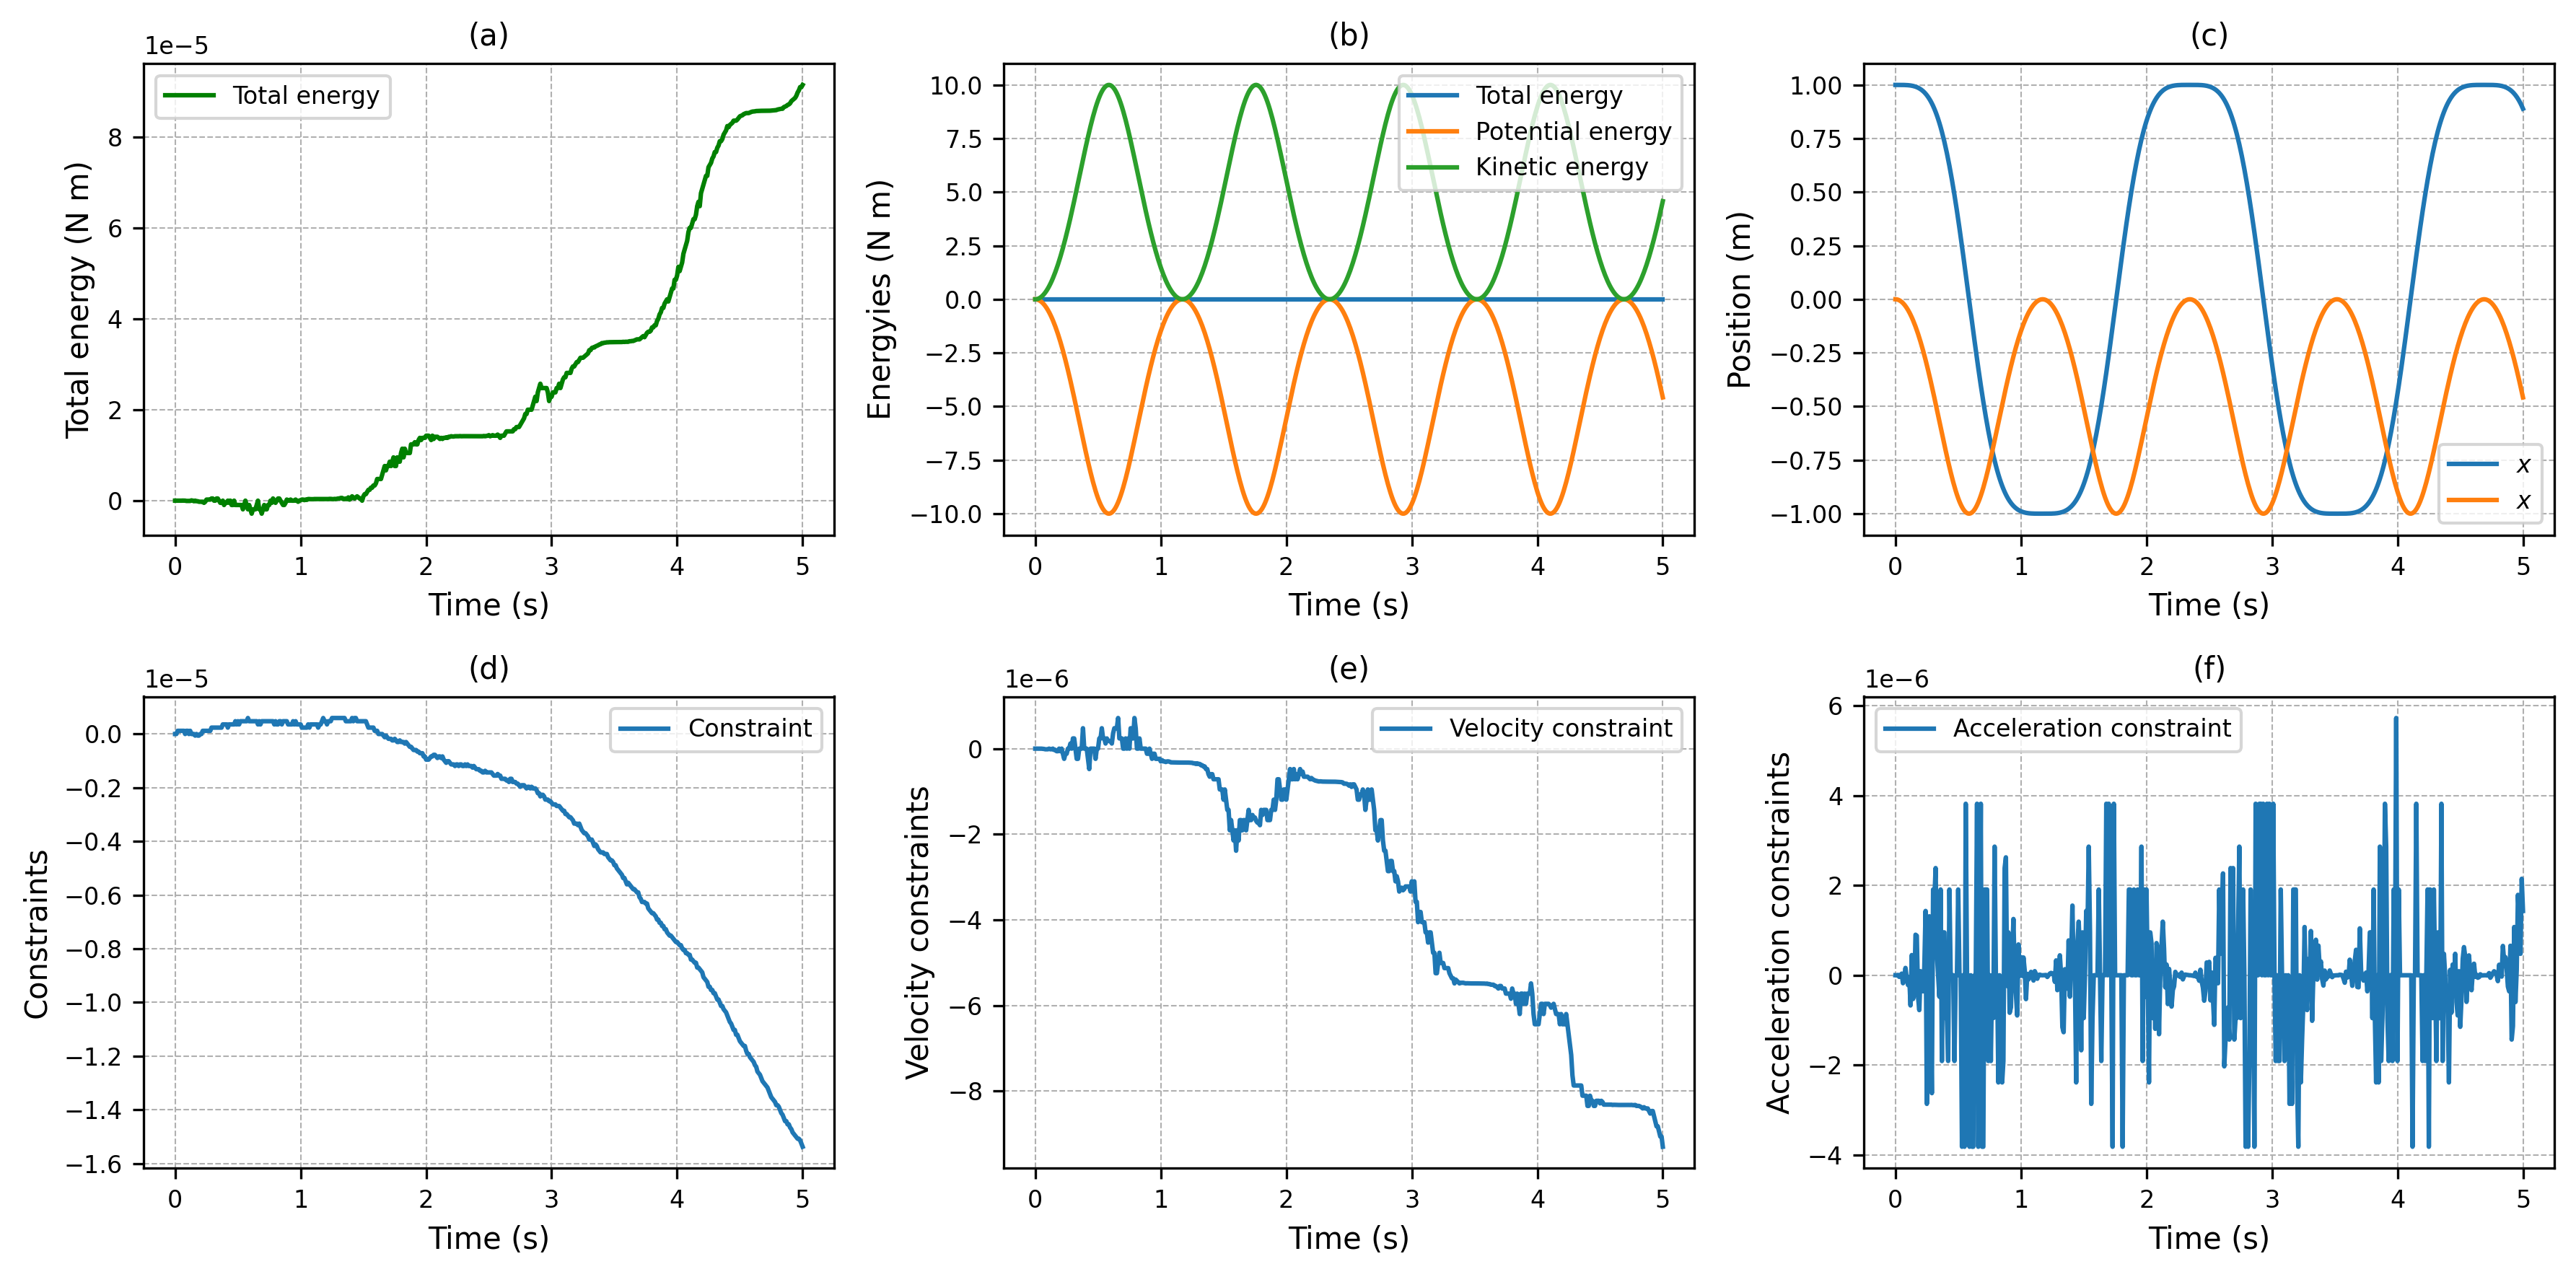

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=Latex_DPI)

subfig = axs[0, 0]
subfig.set_title('(a)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Total energy (N m)')
subfig.plot(data_t, energy, 'g-', label='Total energy')
subfig.legend()

subfig = axs[0, 1]
subfig.set_title('(b)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Energyies (N m)')
subfig.plot(data_t, energy, label='Total energy')
subfig.plot(data_t, potential, label='Potential energy')
subfig.plot(data_t, kinetic, label='Kinetic energy')
subfig.legend()

subfig = axs[0, 2]
subfig.set_title('(c)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Position (m)')
subfig.plot(data_t, q[:, ], label=r'$x$')
subfig.legend()

subfig = axs[1, 0]
subfig.set_title('(d)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Constraints')
subfig.plot(data_t, phi[:, ], label='Constraint')
subfig.legend()

subfig = axs[1, 1]
subfig.set_title('(e)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Velocity constraints')
subfig.plot(data_t, phi_t[:, ], label='Velocity constraint')
subfig.legend()

subfig = axs[1, 2]
subfig.set_title('(f)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Acceleration constraints')
subfig.plot(data_t, phi_tt[:, ], label='Acceleration constraint')
subfig.legend()

plt.tight_layout()

In [7]:
model = DAE_NN(config, logger).to(config.device)
path = "/home/lbu/project/pixels_hnn/ex_single_pendulum3/outputs/pixels-hnn2.tar"
load_network(model, path, config.device)
logger.info("Number of parameters in model: {}".format(count_parameters(model)))

model.dynamics.m_net.mass1, model.dynamics.f_net.F1,

2023-09-26 22:46:30 INFO Number of parameters in model: 2


Successfully loaded pretrained weights from "/home/lbu/project/pixels_hnn/ex_single_pendulum3/outputs/pixels-hnn2.tar"


(Parameter containing:
 tensor([0.0143], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1429], device='cuda:0', requires_grad=True))

In [8]:
y0 = torch.tensor(config.y0, device=config.device, dtype=config.dtype)
y0 = y0.repeat(config.data_num, 1)
y0, y0.shape

data_t, y = ODEIntegrate(
    func=model,
    t0=config.t0,
    t1=config.t1,
    dt=config.dt,
    y0=y0[:,:2*config.dof],
    method=config.ode_solver,
    device=config.device,
    dtype=config.dtype,
    dof=config.dof,
)

yt = torch.stack([dynamics(data_t, yi).clone().detach().cpu() for yi in y])

y = y.squeeze()
y0 = y[0].reshape(1, -1)
yt = yt.squeeze()

# 截断lambda值
y = truncated_lambdas(y, config.dof)
y0 = truncated_lambdas(y0, config.dof)
yt = truncated_lambdas(yt, config.dof)

data_t, y, yt = tensors_to_numpy(data_t, y, yt)

q, qt = np.split(y, 2, axis=-1)
qt, qtt = np.split(yt, 2, axis=-1)
all_states = np.concatenate([q, qt, qtt], axis=-1)
all_states.shape

from dynamic_single_pendulum_DAE import DynamicSinglePendulumDAE
calculator = DynamicSinglePendulumDAE(config, logger).calculator

energy = calculator.energy(q, qt) 
energy_error = calculator.energy(q, qt) - calculator.energy(q, qt)[0]

phi = calculator.phi(q, qt, qtt)
phi_t = calculator.phi_t(q, qt, qtt)
phi_tt = calculator.phi_tt(q, qt, qtt)
kinetic = calculator.kinetic(q, qt)
potential = calculator.potential(q, qt)

solving ODE...: 100%|████████████████████████| 500/500 [00:00<00:00, 579.72it/s]


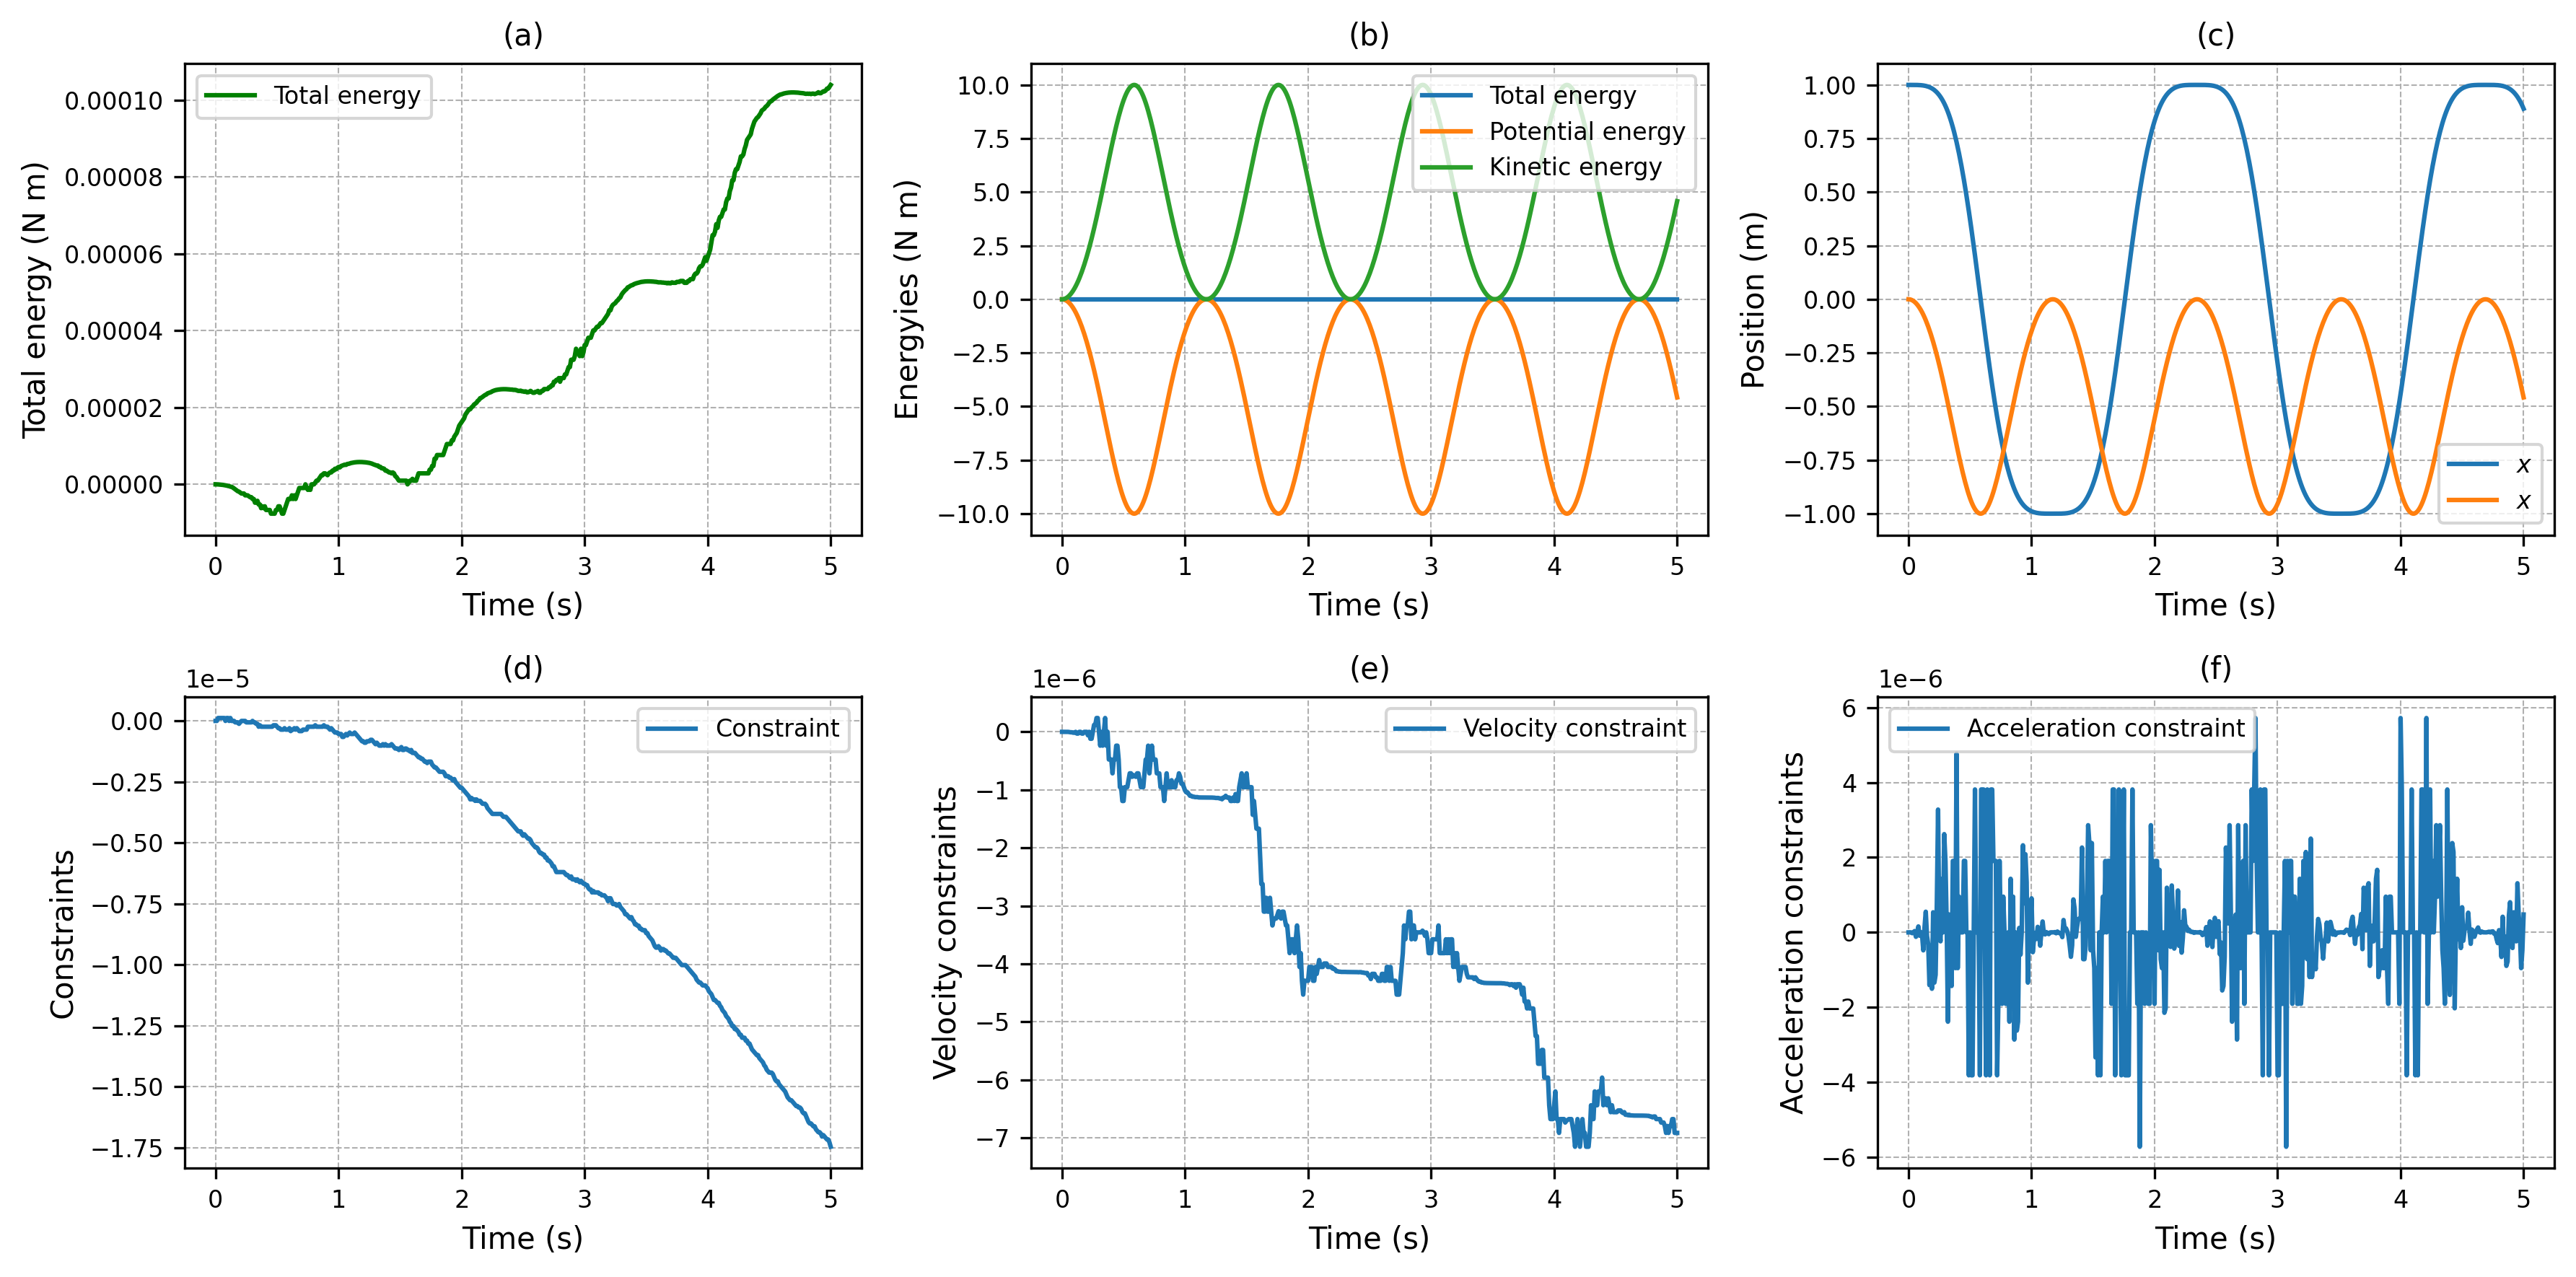

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=Latex_DPI)

subfig = axs[0, 0]
subfig.set_title('(a)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Total energy (N m)')
subfig.plot(data_t, energy, 'g-', label='Total energy')
subfig.legend()

subfig = axs[0, 1]
subfig.set_title('(b)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Energyies (N m)')
subfig.plot(data_t, energy, label='Total energy')
subfig.plot(data_t, potential, label='Potential energy')
subfig.plot(data_t, kinetic, label='Kinetic energy')
subfig.legend()

subfig = axs[0, 2]
subfig.set_title('(c)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Position (m)')
subfig.plot(data_t, q[:, ], label=r'$x$')
subfig.legend()

subfig = axs[1, 0]
subfig.set_title('(d)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Constraints')
subfig.plot(data_t, phi[:, ], label='Constraint')
subfig.legend()

subfig = axs[1, 1]
subfig.set_title('(e)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Velocity constraints')
subfig.plot(data_t, phi_t[:, ], label='Velocity constraint')
subfig.legend()

subfig = axs[1, 2]
subfig.set_title('(f)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Acceleration constraints')
subfig.plot(data_t, phi_tt[:, ], label='Acceleration constraint')
subfig.legend()

plt.tight_layout()

In [10]:
y0 = torch.tensor(config.y0, device=config.device, dtype=config.dtype)
y0 = y0.repeat(config.data_num, 1)
y0, y0.shape
# dataset_path = "/home/lbu/project/pixels_hnn/ex_single_pendulum3/dataset/"

# data = get_data(config, logger, dataset_path)
# y = data["y"].detach().requires_grad_(True).to(config.device).to(config.dtype)
# data_t = data["t"].detach().requires_grad_(True).to(config.device).to(config.dtype)
# yt = data["yt"].detach().requires_grad_(True).to(config.device).to(config.dtype)

dynamics = DynamicSinglePendulumDAE(config,logger)
data_t, y = ODEIntegrate(
    func=dynamics,
    t0=config.t0,
    t1=config.t1,
    dt=config.dt,
    y0=y0,
    method=config.ode_solver,
    device=config.device,
    dtype=config.dtype,
    dof=config.dof,
)
# q, qt, lambdas = torch.tensor_split(d_coords, (self.config.dof, self.config.dof * 2), dim=-1)
# d_coords = torch.cat([q, qt], dim=-1)
# yt = dynamics(t, y)
yt = torch.stack([dynamics(data_t, yi).clone().detach().cpu() for yi in y])

y = y.squeeze()
y0 = y[0].reshape(1, -1)
yt = yt.squeeze()

y = truncated_lambdas(y, config.dof)
y0 = truncated_lambdas(y0, config.dof)
yt = truncated_lambdas(yt, config.dof)

solving ODE...: 100%|████████████████████████| 500/500 [00:00<00:00, 696.12it/s]


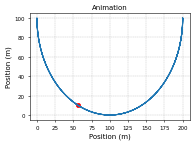

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

# 创建动画
fig, axs = plt.subplots(1, 1, figsize=(4, 3 ), dpi=DPI)
subfig = axs
subfig.set_title('Animation')
subfig.set_xlabel('Position (m)')
subfig.set_ylabel('Position (m)')
subfig.plot((q[:, 0]+1)*100,(q[:, 1]+1)*100)    
subfig.scatter((q[400, 0]+1)*100, (q[400, 1]+1)*100, color='red', marker='o')    
plt.tight_layout()


In [31]:
multiple = 1e3
def encoder_point2pixel(point, multiple):
    point_x = point[:, 0]
    point_y = point[:, 1]
    x = torch.floor((point_x + 1) * multiple).reshape(-1,1)
    y = - torch.floor((point_y) * multiple).reshape(-1,1)
    pixel_point = torch.cat([x, y],dim=-1)
    return pixel_point

def decoder_pixel2point(point, point_next, multiple, dt=0.01):
    point_x = point[:,0]
    point_y = point[:,1]

    point_next_x = point_next[:,0]
    point_next_y = point_next[:,1]

    x = ((point_x/multiple - 1)).reshape(-1,1)
    y = ((- point_y / multiple)).reshape(-1,1)
    
    new_vx = ((point_x - point_next_x)/multiple /dt).reshape(-1,1)
    new_vy = ((point_next_y - point_y)/multiple /dt).reshape(-1,1)
    
    new_point = torch.cat([x, y,new_vx,new_vy],dim=-1)

    return new_point


encoder_point = encoder_point2pixel(y, multiple)
decoder_point = decoder_pixel2point(encoder_point[1:], encoder_point[:-1], multiple)


tensor([[2.0000e+03, -0.0000e+00],
        [1.9990e+03, 1.0000e+00],
        [1.9990e+03, 2.0000e+00],
        ...,
        [1.9140e+03, 4.0500e+02],
        [1.9020e+03, 4.3100e+02],
        [1.8890e+03, 4.5800e+02]], device='cuda:0')

(558, 898)


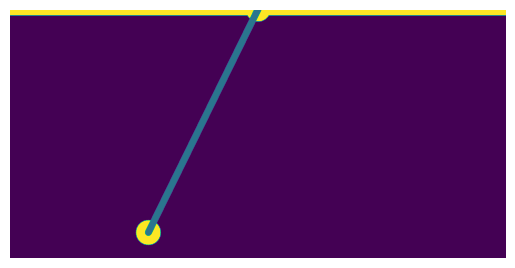

In [39]:
import cv2
import numpy as np

multiple = int(1e3)

# 创建一个空白灰度图像
image_width = multiple+1
image_line = image_width*2
blank_image = np.zeros((image_width, image_line), dtype=np.uint8)

# 天花板
start_point = (0, 0)
end_point = (image_line, 0)
color = 255  
line_thickness = 50
cv2.line(blank_image, start_point, end_point, color, line_thickness)

# 顶端中点
color = 255  
point_coordinates = (int(image_line/2), 0)  
radius = 50
cv2.circle(blank_image, point_coordinates, radius, color, -1) 

# 小球
color = 255  
encoder_point = encoder_point2pixel(y, multiple)
point_coordinates_x = int(tensors_to_numpy(encoder_point[400,0]))
point_coordinates_y = int(tensors_to_numpy(encoder_point[400,1]))
point_coordinates = (point_coordinates_x, point_coordinates_y) 
print(point_coordinates)
radius = 50
cv2.circle(blank_image, point_coordinates, radius, color, -1) 

# 绳子
start_point = (int(image_line/2), 0)
end_point = point_coordinates
color = 100
line_thickness = 25
cv2.line(blank_image, start_point, end_point, color, line_thickness)

blank_image[point_coordinates[1], point_coordinates[0]] = 111

plt.axis('off')

plt.imshow(blank_image)

In [37]:
blank_image
np.where(blank_image == 111)


(array([898]), array([558]))

In [36]:
blank_image[0,986]

100

In [38]:
encoder_point[400]

tensor([558., 898.], device='cuda:0')